# Query Information from API

In [3]:
import numpy as np

In [4]:
# Retrieve date and price from "Daily Transaction Data" API
from fetch_historical_data import *
history_idx30_df = fetch_daily_data()

In [5]:
history_idx30_df

,symbol,date,close,volume,market_cap
0,BUKA.JK,2024-07-23,127,248044100,13094843580416
1,ARTO.JK,2024-07-23,2530,35056400,34707551027200
2,BBRI.JK,2024-07-23,4790,170919500,722288878026752
3,AKRA.JK,2024-07-23,1505,14435800,29704486649856
4,CPIN.JK,2024-07-23,5400,4151500,88549198135296
...,...,...,...,...,...
1907,INCO.JK,2024-10-21,4250,26332400,44794147504128
1908,KLBF.JK,2024-10-21,1660,28486500,76763715600384
1909,ANTM.JK,2024-10-21,1690,243375700,40612053123072
1910,INDF.JK,2024-10-21,7400,8431800,64975183806464


In [6]:
# Enforce in case any column needs conversion (e.g., 'close', 'volume', 'market_cap')
history_idx30_df['close'] = pd.to_numeric(history_idx30_df['close'], errors='coerce')
history_idx30_df['volume'] = pd.to_numeric(history_idx30_df['volume'], errors='coerce')
history_idx30_df['market_cap'] = pd.to_numeric(history_idx30_df['market_cap'], errors='coerce')

# Check for the first few rows to ensure everything is correct
print(history_idx30_df)


       symbol        date  close     volume       market_cap
0     BUKA.JK  2024-07-23    127  248044100   13094843580416
1     ARTO.JK  2024-07-23   2530   35056400   34707551027200
2     BBRI.JK  2024-07-23   4790  170919500  722288878026752
3     AKRA.JK  2024-07-23   1505   14435800   29704486649856
4     CPIN.JK  2024-07-23   5400    4151500   88549198135296
...       ...         ...    ...        ...              ...
1907  INCO.JK  2024-10-21   4250   26332400   44794147504128
1908  KLBF.JK  2024-10-21   1660   28486500   76763715600384
1909  ANTM.JK  2024-10-21   1690  243375700   40612053123072
1910  INDF.JK  2024-10-21   7400    8431800   64975183806464
1911  CPIN.JK  2024-10-21   5050    5445000   82809897091072

[1912 rows x 5 columns]


In [7]:
history_idx30_df.groupby('symbol').date.nunique()

symbol
ACES.JK    64
ADRO.JK    64
AKRA.JK    63
AMRT.JK    64
ANTM.JK    64
ARTO.JK    63
ASII.JK    64
BBCA.JK    63
BBNI.JK    64
BBRI.JK    63
BMRI.JK    63
BRPT.JK    63
BUKA.JK    63
CPIN.JK    64
GOTO.JK    63
ICBP.JK    64
INCO.JK    64
INDF.JK    64
INKP.JK    64
ITMG.JK    64
KLBF.JK    64
MDKA.JK    64
MEDC.JK    64
PGAS.JK    64
PGEO.JK    64
PTBA.JK    64
SMGR.JK    64
TLKM.JK    64
UNTR.JK    64
UNVR.JK    64
Name: date, dtype: int64

In [8]:
# Query historical market cap data
market_cap_df = fetch_mcap_data()

# 1 - Market Momentum - IDX Composite Momentum


Calculate Market Momentum Index using the SMA method and aggregate results on a daily basis.

Parameters:

* daily_data_df (DataFrame): DataFrame containing at least 'symbol', 'date', and 'close' columns.

* sma_period: Number of days for the SMA calculation (default is 7).

* min_momentum: Minimum expected momentum to scale the index (default is -5%).

* max_momentum: Maximum expected momentum to scale the index (default is +5%).

Returns:

DataFrame: DataFrame with daily market momentum index.


In [9]:
daily_data_df_momentum = history_idx30_df.copy()

In [10]:
sma_period=7
min_momentum=-5
max_momentum=5

In [11]:
# Calculate SMA for each stock
daily_data_df_momentum['sma'] = daily_data_df_momentum.groupby('symbol')['close'].transform(lambda x: x.rolling(window=sma_period, min_periods=1).mean())

In [12]:
daily_data_df_momentum[['symbol','sma']]

,symbol,sma
0,BUKA.JK,127.000000
1,ARTO.JK,2530.000000
2,BBRI.JK,4790.000000
3,AKRA.JK,1505.000000
4,CPIN.JK,5400.000000
...,...,...
1907,INCO.JK,4165.714286
1908,KLBF.JK,1711.428571
1909,ANTM.JK,1614.285714
1910,INDF.JK,7203.571429


In [13]:
# Calculate the percentage difference from the SMA
# Small constant to avoid division by zero
epsilon = 1e-9
daily_data_df_momentum['momentum_sma'] = ((daily_data_df_momentum['close'] - daily_data_df_momentum['sma']) / (daily_data_df_momentum['sma'] + epsilon)) * 100

In [14]:
daily_data_df_momentum[['symbol','momentum_sma']]

,symbol,momentum_sma
0,BUKA.JK,0.000000
1,ARTO.JK,0.000000
2,BBRI.JK,0.000000
3,AKRA.JK,0.000000
4,CPIN.JK,0.000000
...,...,...
1907,INCO.JK,2.023320
1908,KLBF.JK,-3.005008
1909,ANTM.JK,4.690265
1910,INDF.JK,2.726822


In [15]:
# Remove any NaNs in case any
daily_data_df_momentum = daily_data_df_momentum.dropna(subset=['momentum_sma'])

In [16]:
# Scale the momentum to a 0-100 range for the Fear and Greed Index
def scale_to_100(value, min_val, max_val):

  scaled_value = (value - min_val) / (max_val - min_val) * 100

  return np.clip(scaled_value, 0, 100)

In [17]:
daily_data_df_momentum['momentum_scaled'] = daily_data_df_momentum['momentum_sma'].apply(lambda x: scale_to_100(x, min_momentum, max_momentum))

In [18]:
daily_data_df_momentum[['symbol','momentum_scaled']]

,symbol,momentum_scaled
0,BUKA.JK,50.000000
1,ARTO.JK,50.000000
2,BBRI.JK,50.000000
3,AKRA.JK,50.000000
4,CPIN.JK,50.000000
...,...,...
1907,INCO.JK,70.233196
1908,KLBF.JK,19.949917
1909,ANTM.JK,96.902655
1910,INDF.JK,77.268220


In [19]:
# Calculate the Market Momentum Index on a daily basis
daily_momentum_index = daily_data_df_momentum.groupby('date')['momentum_scaled'].mean().reset_index()

In [20]:
daily_momentum_index

,date,momentum_scaled
0,2024-07-23,50.000000
1,2024-07-24,46.022622
2,2024-07-25,43.231244
3,2024-07-26,49.945080
4,2024-07-29,47.492180
...,...,...
59,2024-10-15,55.609823
60,2024-10-16,57.956718
61,2024-10-17,59.956895
62,2024-10-18,60.242725


In [21]:
print('Today´s Market Momentum Fear and Greed index is: ', daily_momentum_index.iloc[-1,-1])

Today´s Market Momentum Fear and Greed index is:  58.26552937205858


KeyError: 'market_momentum_index'

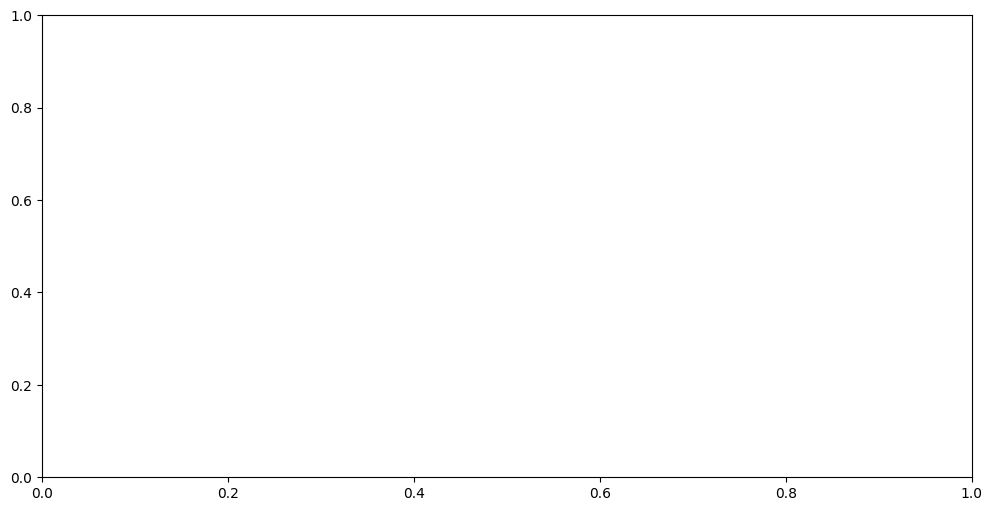

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_momentum_index['date'], daily_momentum_index['market_momentum_index'], color='blue', linewidth=2, label='Market Momentum Index')

# Highlight the "Fear" and "Greed" zones
ax.fill_between(daily_momentum_index['date'], 0, 50, color='red', alpha=0.2, label='Fear Zone')
ax.fill_between(daily_momentum_index['date'], 50, 100, color='green', alpha=0.2, label='Greed Zone')

# Formatting the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)

# Adding labels and title
plt.title("Market Momentum: Fear and Greed Index Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Momentum Scaled Index", fontsize=12)


plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# 2 - Stock Price Strength

In [24]:
# Create a copy of the original DataFrame
df_copy_ps = history_idx30_df.copy()

In [25]:
# Calculate the daily percentage change in 'close' price for each symbol on the copy
df_copy_ps['daily_return'] = df_copy_ps.groupby('symbol')['close'].pct_change() * 100

In [26]:
# Calculate the 7-day SMA of the daily returns on the copy
df_copy_ps['sma_7d_return'] = df_copy_ps.groupby('symbol')['daily_return'].transform(lambda x: x.rolling(window=7).mean())

In [27]:
# Handle zero division by replacing any infinite or NaN values in 'sma_7d_return' with zeros
df_copy_ps['sma_7d_return'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_copy_ps['sma_7d_return'].fillna(0, inplace=True)

C:\Users\Johann\AppData\Local\Temp\ipykernel_7544\1308674173.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy_ps['sma_7d_return'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Johann\AppData\Local\Temp\ipykernel_7544\1308674173.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [28]:
# Scale the SMA results for fear and greed index on a 0 to 100 scale
# Calculate the min and max of the SMA to normalize
min_sma = df_copy_ps['sma_7d_return'].min()
max_sma = df_copy_ps['sma_7d_return'].max()

In [29]:
# Avoid division by zero in scaling
if max_sma - min_sma == 0:
    df_copy_ps['scaled_strength_index'] = 0
else:
    df_copy_ps['scaled_strength_index'] = ((df_copy_ps['sma_7d_return'] - min_sma) / (max_sma - min_sma)) * 100

In [30]:
df_copy_ps[['symbol', 'date', 'scaled_strength_index']].dropna()

,symbol,date,scaled_strength_index
0,BUKA.JK,2024-07-23,41.097722
1,ARTO.JK,2024-07-23,41.097722
2,BBRI.JK,2024-07-23,41.097722
3,AKRA.JK,2024-07-23,41.097722
4,CPIN.JK,2024-07-23,41.097722
...,...,...,...
1907,INCO.JK,2024-10-21,48.478271
1908,KLBF.JK,2024-10-21,43.320610
1909,ANTM.JK,2024-10-21,68.232248
1910,INDF.JK,2024-10-21,55.608289


In [32]:
# Group by 'date' and calculate the mean of 'scaled_strength_index' for each day
daily_mean_strength_index = df_copy_ps.groupby('date')['scaled_strength_index'].mean().reset_index()

In [33]:
daily_mean_strength_index

,date,scaled_strength_index
0,2024-07-23,41.097722
1,2024-07-24,41.097722
2,2024-07-25,41.097722
3,2024-07-26,41.097722
4,2024-07-29,41.097722
...,...,...
59,2024-10-15,45.049467
60,2024-10-16,42.758110
61,2024-10-17,45.071591
62,2024-10-18,47.441832


In [34]:
print ('Today´s Stock Price Strength Fear and Greed index is: ', daily_mean_strength_index.iloc[-1,-1])

Today´s Stock Price Strength Fear and Greed index is:  48.05877333465128


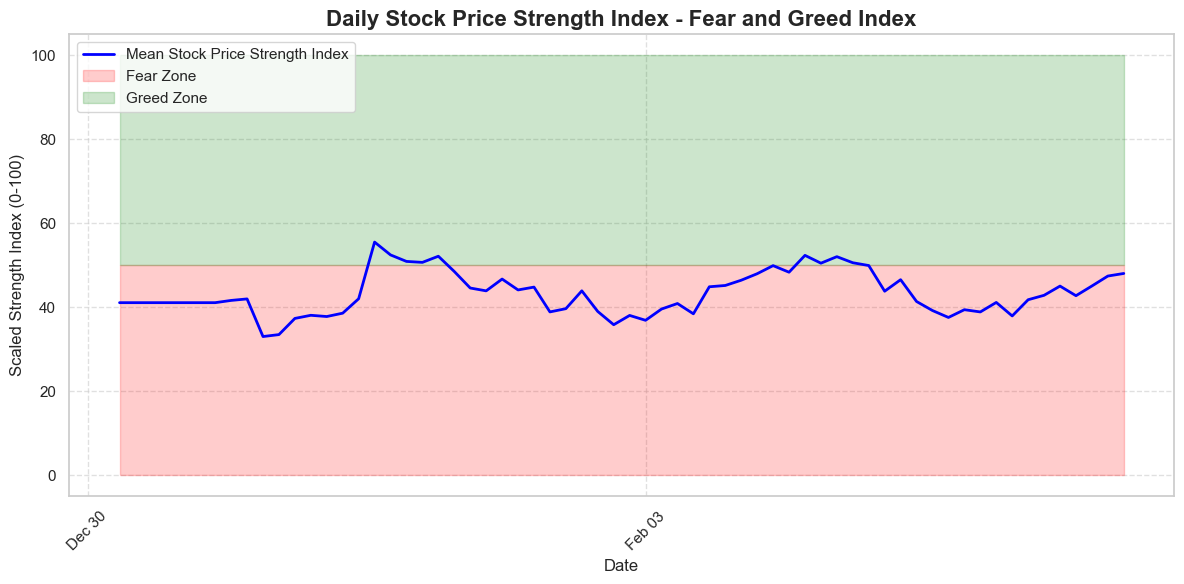

In [35]:
import seaborn as sns

# Set up the plot style
sns.set(style="whitegrid")

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the daily mean strength index
ax.plot(daily_mean_strength_index['date'], daily_mean_strength_index['scaled_strength_index'], color='blue', linewidth=2, label='Mean Stock Price Strength Index')

# Highlight the "Fear" and "Greed" zones
ax.fill_between(daily_mean_strength_index['date'], 0, 50, color='red', alpha=0.2, label='Fear Zone')
ax.fill_between(daily_mean_strength_index['date'], 50, 100, color='green', alpha=0.2, label='Greed Zone')

# Formatting the x-axis for readability
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
plt.xticks(rotation=45)

# Adding labels and title
plt.title("Daily Stock Price Strength Index - Fear and Greed Index", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Scaled Strength Index (0-100)", fontsize=12)

# Adding grid for better visual guidance
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Adding legend
plt.legend(loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

# 3 - Volatility

In [36]:
# consolidate the original df
history_idx30_df = history_idx30_df[['symbol', 'date', 'close', 'volume', 'market_cap']]

In [37]:
# Create a copy of the original DataFrame
df_copy_vol = history_idx30_df.copy()

In [38]:
df_copy_vol.head()

,symbol,date,close,volume,market_cap
0,BUKA.JK,2024-07-23,127,248044100,13094843580416
1,ARTO.JK,2024-07-23,2530,35056400,34707551027200
2,BBRI.JK,2024-07-23,4790,170919500,722288878026752
3,AKRA.JK,2024-07-23,1505,14435800,29704486649856
4,CPIN.JK,2024-07-23,5400,4151500,88549198135296


In [39]:
history_idx30_df.head()

,symbol,date,close,volume,market_cap
0,BUKA.JK,2024-07-23,127,248044100,13094843580416
1,ARTO.JK,2024-07-23,2530,35056400,34707551027200
2,BBRI.JK,2024-07-23,4790,170919500,722288878026752
3,AKRA.JK,2024-07-23,1505,14435800,29704486649856
4,CPIN.JK,2024-07-23,5400,4151500,88549198135296


In [40]:
# Calculate the daily percentage change in 'close' price for each symbol
df_copy_vol['daily_return'] = df_copy_vol.groupby('symbol')['close'].pct_change()

In [41]:
# Calculate the 7-day rolling standard deviation (volatility) of the daily returns for each symbol
df_copy_vol['volatility_7d'] = df_copy_vol.groupby('symbol')['daily_return'].transform(lambda x: x.rolling(window=7).std())

In [42]:
# Handle zero division by replacing any infinite or NaN values in 'volatility_7d' with zeros
df_copy_vol['volatility_7d'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_copy_vol['volatility_7d'].fillna(0, inplace=True)

C:\Users\Johann\AppData\Local\Temp\ipykernel_7544\3459160738.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy_vol['volatility_7d'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Johann\AppData\Local\Temp\ipykernel_7544\3459160738.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

In [43]:
# Scale the volatility on a 0 to 100 scale for the fear and greed index context
min_vol = df_copy_vol['volatility_7d'].min()
max_vol = df_copy_vol['volatility_7d'].max()

In [44]:
# Avoid division by zero in scaling
if max_vol - min_vol == 0:
    df_copy_vol['scaled_volatility_index'] = 0
else:
    df_copy_vol['scaled_volatility_index'] = ((df_copy_vol['volatility_7d'] - min_vol) / (max_vol - min_vol)) * 100

In [45]:
df_copy_vol = df_copy_vol[['symbol', 'date', 'scaled_volatility_index']].dropna()

In [46]:
df_copy_vol = df_copy_vol.groupby('date')['scaled_volatility_index'].mean().reset_index()

In [47]:
df_copy_vol

,date,scaled_volatility_index
0,2024-07-23,0.000000
1,2024-07-24,0.000000
2,2024-07-25,0.000000
3,2024-07-26,0.000000
4,2024-07-29,0.000000
...,...,...
59,2024-10-15,18.316627
60,2024-10-16,16.375113
61,2024-10-17,14.994547
62,2024-10-18,14.963958


In [48]:
print('Today´s Volatility Fear and Greed index is: ', df_copy_vol.iloc[-1,-1])

Today´s Volatility Fear and Greed index is:  14.652515410754775


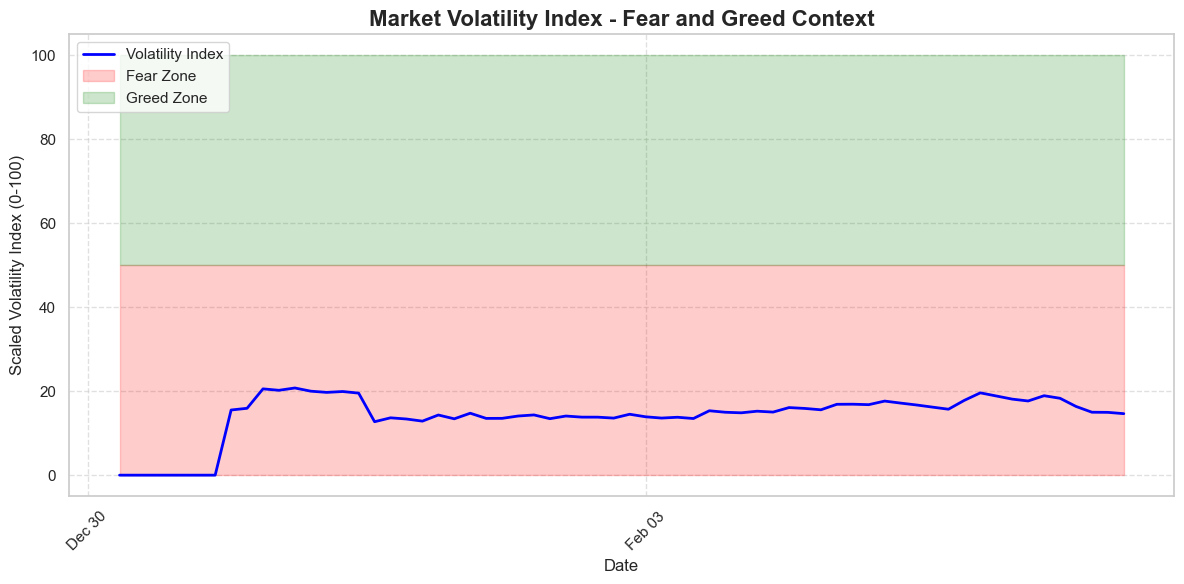

In [49]:
sns.set(style="whitegrid")

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scaled volatility index over time
ax.plot(df_copy_vol['date'], df_copy_vol['scaled_volatility_index'], color='blue', linewidth=2, label='Volatility Index')

# Highlight the "Fear" and "Greed" zones
ax.fill_between(df_copy_vol['date'], 0, 50, color='red', alpha=0.2, label='Fear Zone')
ax.fill_between(df_copy_vol['date'], 50, 100, color='green', alpha=0.2, label='Greed Zone')

# Formatting the x-axis for readability
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
plt.xticks(rotation=45)

# Adding labels and title
plt.title("Market Volatility Index - Fear and Greed Context", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Scaled Volatility Index (0-100)", fontsize=12)

# Adding grid for better visual guidance
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Adding legend
plt.legend(loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

# 4 - Volume Breadth

In [50]:
history_idx30_df

,symbol,date,close,volume,market_cap
0,BUKA.JK,2024-07-23,127,248044100,13094843580416
1,ARTO.JK,2024-07-23,2530,35056400,34707551027200
2,BBRI.JK,2024-07-23,4790,170919500,722288878026752
3,AKRA.JK,2024-07-23,1505,14435800,29704486649856
4,CPIN.JK,2024-07-23,5400,4151500,88549198135296
...,...,...,...,...,...
1907,INCO.JK,2024-10-21,4250,26332400,44794147504128
1908,KLBF.JK,2024-10-21,1660,28486500,76763715600384
1909,ANTM.JK,2024-10-21,1690,243375700,40612053123072
1910,INDF.JK,2024-10-21,7400,8431800,64975183806464


In [51]:
df_vb_copy = history_idx30_df.copy()

In [52]:
# Identify advancing and declining stocks
# Calculate whether the stock is advancing or declining based on the 'close' price
df_vb_copy['advancing'] = df_vb_copy.groupby('symbol')['close'].diff() > 0
df_vb_copy['declining'] = df_vb_copy.groupby('symbol')['close'].diff() < 0

In [53]:
# Calculate total volume of advancing and declining stocks for each date
# Advancing volume
df_vb_copy['advancing_volume'] = df_vb_copy['volume'] * df_vb_copy['advancing']
# Declining volume
df_vb_copy['declining_volume'] = df_vb_copy['volume'] * df_vb_copy['declining']

In [54]:
# Group by date to get total advancing and declining volumes for each day
daily_volume = df_vb_copy.groupby('date').agg({
    'advancing_volume': 'sum',
    'declining_volume': 'sum'
}).reset_index()

In [55]:
# Calculate Volume Breadth
# Avoid division by zero by handling cases where declining volume is zero
daily_volume['volume_breadth'] = daily_volume.apply(
    lambda row: row['advancing_volume'] / row['declining_volume'] if row['declining_volume'] != 0 else np.nan,axis=1
)

In [56]:
# Apply the 7-day SMA to the Volume Breadth to smooth the values
daily_volume['sma_7d_vb'] = daily_volume['volume_breadth'].rolling(window=7).mean()

In [57]:
# Handle NaN or infinite values in the SMA with zeros (for stability)
daily_volume['sma_7d_vb'].replace([np.inf, -np.inf], np.nan, inplace=True)
daily_volume['sma_7d_vb'].fillna(0, inplace=True)

C:\Users\Johann\AppData\Local\Temp\ipykernel_7544\1520035415.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_volume['sma_7d_vb'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Johann\AppData\Local\Temp\ipykernel_7544\1520035415.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [58]:
# Scale the Volume Breadth for the fear and greed index context
# Min and max for scaling
min_vb = daily_volume['sma_7d_vb'].min()
max_vb = daily_volume['sma_7d_vb'].max()

In [59]:
# Scale between 0 and 100, with protection against division by zero
if max_vb - min_vb == 0:
    daily_volume['scaled_vb'] = 0
else:
    daily_volume['scaled_vb'] = ((daily_volume['sma_7d_vb'] - min_vb) / (max_vb - min_vb)) * 100

In [60]:
# Replace 0 and 100 values with the mean
mean_scaled_vb = daily_volume['scaled_vb'].mean()
daily_volume['scaled_vb'] = daily_volume['scaled_vb'].apply(lambda x: mean_scaled_vb if x == 0 or x == 100 else x)

In [61]:
daily_volume[['date', 'scaled_vb']]

,date,scaled_vb
0,2024-07-23,29.982242
1,2024-07-24,29.982242
2,2024-07-25,29.982242
3,2024-07-26,29.982242
4,2024-07-29,29.982242
...,...,...
59,2024-10-15,25.337819
60,2024-10-16,26.651926
61,2024-10-17,24.634483
62,2024-10-18,25.048134


In [62]:
print('Today´s Market Volume Breadth Fear and Greed Index is: ', daily_volume.iloc[-1,-1])

Today´s Market Volume Breadth Fear and Greed Index is:  26.64954377178443


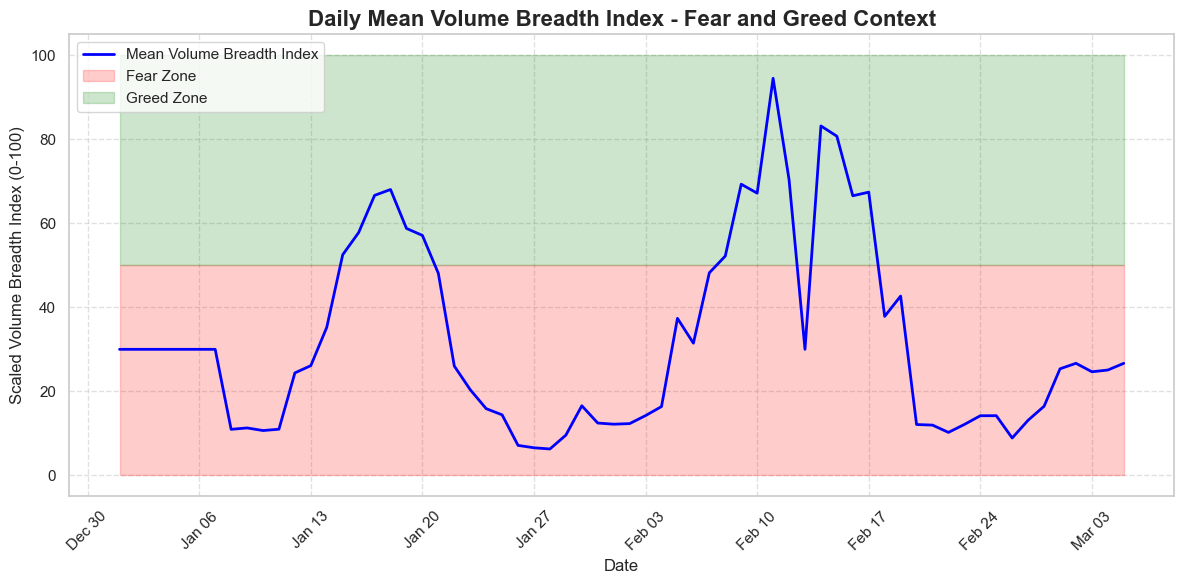

In [63]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the daily mean volume breadth
ax.plot(daily_volume['date'], daily_volume['scaled_vb'], color='blue', linewidth=2, label='Mean Volume Breadth Index')

# Highlight the "Fear" and "Greed" zones
ax.fill_between(daily_volume['date'], 0, 50, color='red', alpha=0.2, label='Fear Zone')
ax.fill_between(daily_volume['date'], 50, 100, color='green', alpha=0.2, label='Greed Zone')

# Show dates on a weekly basis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Show weekly dates
plt.xticks(rotation=45)


plt.title("Daily Mean Volume Breadth Index - Fear and Greed Context", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Scaled Volume Breadth Index (0-100)", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 5 - Safe Heaven Demand

In [64]:
df_shd_copy = history_idx30_df.copy()

In [65]:
# Identify advancing and declining stocks based on market cap
# Calculate whether the stock is advancing or declining based on the 'market_cap'
df_shd_copy['advancing'] = df_shd_copy.groupby('symbol')['market_cap'].diff() > 0
df_shd_copy['declining'] = df_shd_copy.groupby('symbol')['market_cap'].diff() < 0

In [66]:
# Calculate total market cap of advancing and declining stocks for each date
# Advancing market cap
df_shd_copy['advancing_market_cap'] = df_shd_copy['market_cap'] * df_shd_copy['advancing']
# Declining market cap
df_shd_copy['declining_market_cap'] = df_shd_copy['market_cap'] * df_shd_copy['declining']

In [67]:
# Group by date to get total advancing and declining market caps for each day
daily_market_cap = df_shd_copy.groupby('date').agg({
    'advancing_market_cap': 'sum',
    'declining_market_cap': 'sum'
}).reset_index()

In [68]:
# Calculate Safe Haven Demand with zero division handling
daily_market_cap['safe_haven_demand'] = daily_market_cap.apply(
    lambda row: 100 - (row['advancing_market_cap'] / row['declining_market_cap'] * 100)
                if row['declining_market_cap'] != 0 else 100,
    axis=1
)

In [69]:
daily_market_cap

,date,advancing_market_cap,declining_market_cap,safe_haven_demand
0,2024-07-23,0,0,100.000000
1,2024-07-24,685789155426304,3012058665713664,77.231879
2,2024-07-25,2241540115136512,2305083100364800,2.756646
3,2024-07-26,1907599365636096,2528222205968384,24.547796
4,2024-07-29,1931743753626324,2424338537517518,20.318729
...,...,...,...,...
59,2024-10-15,3131869826646016,1252611833462784,-150.027163
60,2024-10-16,3715370744545280,900961235107840,-312.378535
61,2024-10-17,3988555033913387,706030132295395,-464.927027
62,2024-10-18,4309959067041792,669298418778112,-543.951778


In [70]:
# Apply SMA (Simple Moving Average) method over 7 days
daily_market_cap['sma_safe_haven_demand'] = daily_market_cap['safe_haven_demand'].rolling(window=7).mean()

In [71]:
# Handle NaN or infinite values, fill them with zeros or appropriate values
daily_market_cap['sma_safe_haven_demand'].replace([np.inf, -np.inf], np.nan, inplace=True)
daily_market_cap['sma_safe_haven_demand'].fillna(100, inplace=True)

C:\Users\Johann\AppData\Local\Temp\ipykernel_7544\3327070506.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_market_cap['sma_safe_haven_demand'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Johann\AppData\Local\Temp\ipykernel_7544\3327070506.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [72]:
# Scale the Safe Haven Demand between 0 and 100 for fear and greed context
min_shd = daily_market_cap['sma_safe_haven_demand'].min()
max_shd = daily_market_cap['sma_safe_haven_demand'].max()

if max_shd - min_shd == 0:
    daily_market_cap['scaled_safe_haven_demand'] = 0
else:
    daily_market_cap['scaled_safe_haven_demand'] = ((daily_market_cap['sma_safe_haven_demand'] - min_shd) / (max_shd - min_shd)) * 100

In [73]:
# Replace values that reach 100 with the mean value of 'scaled_safe_haven_demand'
mean_scaled_shd = daily_market_cap['scaled_safe_haven_demand'].mean()
daily_market_cap['scaled_safe_haven_demand'] = daily_market_cap['scaled_safe_haven_demand'].apply(
    lambda x: mean_scaled_shd if x == 100 else x
)

In [74]:
daily_market_cap[['date', 'scaled_safe_haven_demand']]

,date,scaled_safe_haven_demand
0,2024-07-23,47.766013
1,2024-07-24,47.766013
2,2024-07-25,47.766013
3,2024-07-26,47.766013
4,2024-07-29,47.766013
...,...,...
59,2024-10-15,49.610233
60,2024-10-16,40.791631
61,2024-10-17,35.845767
62,2024-10-18,16.944089


In [75]:
print('Today´s Safe Heaven Demand Fear and Greed index is: ', daily_market_cap.iloc[-1, -1])

Today´s Safe Heaven Demand Fear and Greed index is:  21.549546233083923


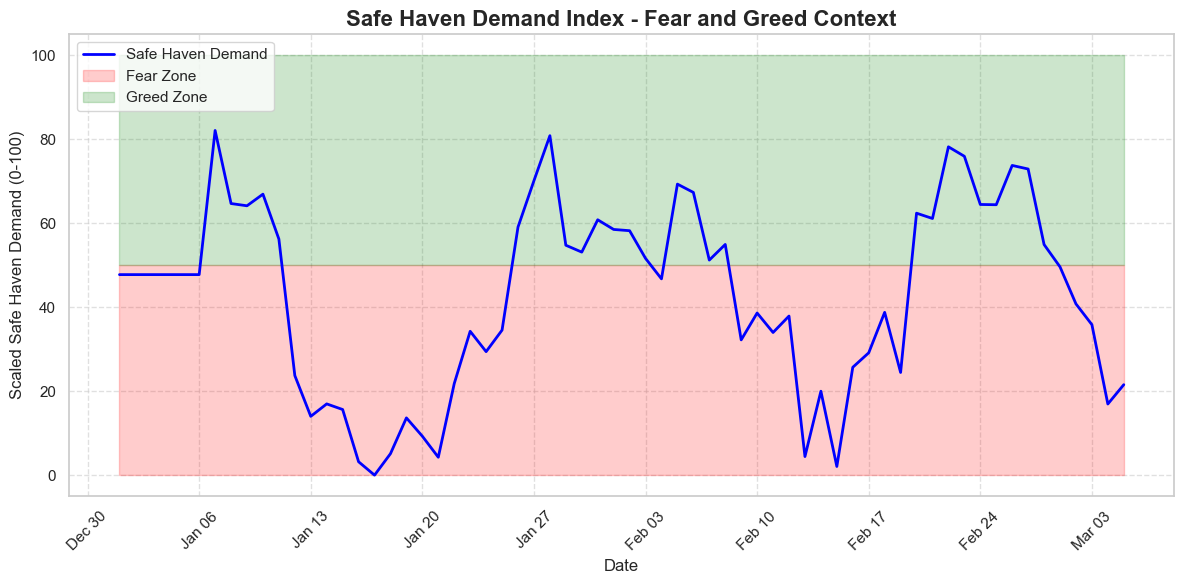

In [76]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scaled Safe Haven Demand over time
ax.plot(daily_market_cap['date'], daily_market_cap['scaled_safe_haven_demand'], color='blue', linewidth=2, label='Safe Haven Demand')

# Highlight the "Fear" and "Greed" zones
ax.fill_between(daily_market_cap['date'], 0, 50, color='red', alpha=0.2, label='Fear Zone')
ax.fill_between(daily_market_cap['date'], 50, 100, color='green', alpha=0.2, label='Greed Zone')

# Set x-axis to show dates on a weekly basis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Show dates on a weekly basis
plt.xticks(rotation=45)


plt.title("Safe Haven Demand Index - Fear and Greed Context", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Scaled Safe Haven Demand (0-100)", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 12 - The Buffett Indicator

The buffett Indicator is Indonesian total nominal GDP divided Indonesian's total stock market value.

Indonesian's total GDP in year 2024 is $1.47 trillion (nominal; 2024 est.) - Source from Wikipedia.

In [78]:
market_cap_df

,date,idx_total_market_cap
0,2024-07-23,12328150157278341
1,2024-07-24,12273456841099059
2,2024-07-25,12208073973540205
3,2024-07-26,12299299470116717
4,2024-07-29,12316013076207233
...,...,...
59,2024-10-15,12637110240060057
60,2024-10-16,12725585259557529
61,2024-10-17,12885138900977256
62,2024-10-18,13091802115745433


In [79]:
# Indonesian GDP for 2024 in Indonesian Rupiah (IDR)
# Using an approximate exchange rate: 1 USD = 15,000 IDR
usd_to_idr_exchange_rate = 15000
indonesia_gdp_idr = 1.47 * 10**12 * usd_to_idr_exchange_rate  # 1.47 trillion USD to IDR

In [81]:
market_cap_df['buffett_indicator'] = (market_cap_df['idx_total_market_cap'] / indonesia_gdp_idr) * 100

In [82]:
# Drop rows with NaN values in the 'scaled_buffett_indicator' column
market_cap_df = market_cap_df.dropna(subset=['buffett_indicator'])

In [83]:
market_cap_df

,date,idx_total_market_cap,buffett_indicator
0,2024-07-23,12328150157278341,55.909978
1,2024-07-24,12273456841099059,55.661936
2,2024-07-25,12208073973540205,55.365415
3,2024-07-26,12299299470116717,55.779136
4,2024-07-29,12316013076207233,55.854935
...,...,...,...
59,2024-10-15,12637110240060057,57.311158
60,2024-10-16,12725585259557529,57.712405
61,2024-10-17,12885138900977256,58.436004
62,2024-10-18,13091802115745433,59.373252


In [84]:
print('Today´s Buffett Indicator Fear and Greed index is: ', market_cap_df.iloc[-1,-1])

Today´s Buffett Indicator Fear and Greed index is:  31.73470852667675


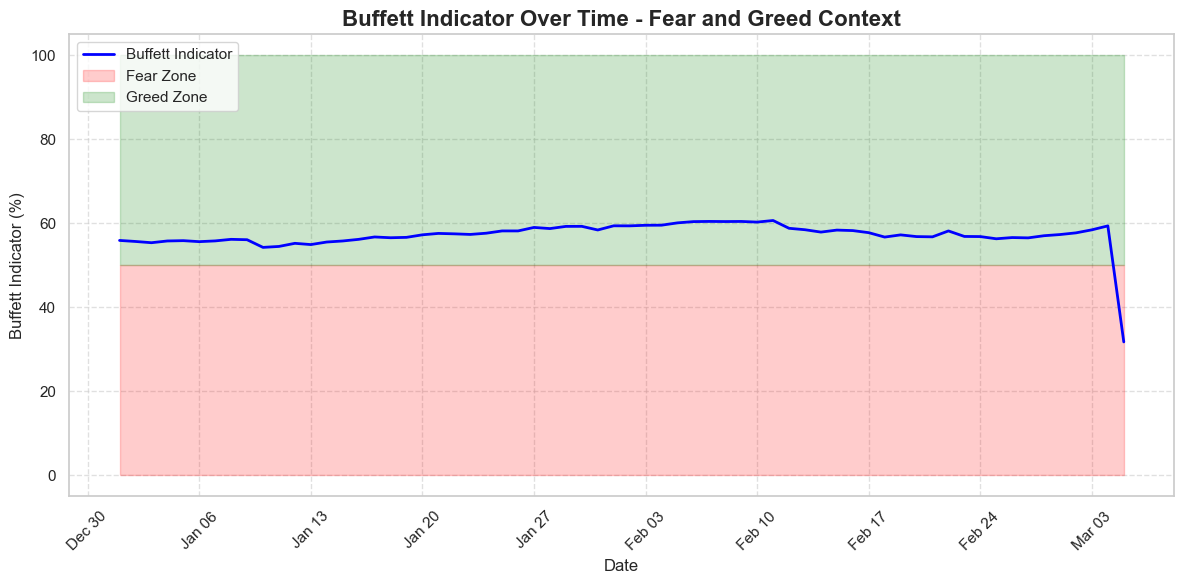

In [85]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the Buffett Indicator over time
ax.plot(market_cap_df['date'], market_cap_df['buffett_indicator'], color='blue', linewidth=2, label='Buffett Indicator')

# Highlight Fear and Greed zones (Assuming > 50 is Greed and < 50 is Fear for demonstration)
ax.fill_between(market_cap_df['date'], 0, 50, color='red', alpha=0.2, label='Fear Zone')
ax.fill_between(market_cap_df['date'], 50, 100, color='green', alpha=0.2, label='Greed Zone')

# Set x-axis to show dates on a weekly basis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Set dates to show weekly
plt.xticks(rotation=45)

# Adding labels and title
plt.title("Buffett Indicator Over Time - Fear and Greed Context", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Buffett Indicator (%)", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()